# Including sky localization

Before starting, let's first familiarize with sky localization maps:

https://samueleronchini.github.io/acme_tutorials/alerts/skymaps.html

In [5]:
from plot_config import setup_matplotlib_style

import matplotlib.pyplot as plt

# Configure matplotlib with high-quality settings
setup_matplotlib_style()

## Spatio-temporal joint FAR

In [6]:
from astropy.table import QTable
from ligo.raven import gracedb_events, search

skymap_grb = QTable.read('./754189311_0_n_PROBMAP.fits')

skymap_gw = QTable.read('./Bilby.multiorder.fits')

tl, th = -10, 20
se_far = 9.503e-10  # Hz
far_ext = 1 / 44 / 60  # 1/44 min

far_joint = search.coinc_far(se_far, tl, th,
                far_ext = far_ext,
                joint_far_method = 'targeted', # 'targeted' or 'untargeted'
                ext_search = 'SubGRBTargeted', # "GRB", "SubGRB", "SubGRBTargeted", "MDC", or "HEN" --> if you don't specify joint_far_method, you must specify ext_search
                # {'GRB', 'SubGRB', 'HEN'} --> uses untargeted
                # {'SubGRBTargeted'} --> uses targeted
                ext_pipeline = 'Swift', # --> if you don't specify far_ext_thresh, you must specify ext_pipeline
                gw_skymap=skymap_gw,
                ext_skymap=skymap_grb)

## Sky overlap integral

In [7]:
sky_overlap = search.skymap_overlap_integral(skymap_gw, ext_skymap=skymap_grb)


:::{note}
If both maps are multi-order, then both maps are internally upsampled to the highest HEALPix depth present among the two. If only the external map if flat, for each pixel of the MOC GW map the corrisponding prob density of the external map is computed in the same position. If both flat, a simple element-wise multiplication is done.
:::

## Sky overlap integral for external precise localization

In [8]:
import ligo.skymap.io.fits

gw_map, _ = ligo.skymap.io.fits.read_sky_map('Bilby.multiorder.fits', nest=True)
sky_overlap_point = search.skymap_overlap_integral(gw_map,
                            ra=90, dec=30) 
# use the gw map in flat format. The functions seems to not handle MOC skymaps when using ext rea and dec 
sky_overlap_point

np.float64(1.4768264524886637e-84)

## Combining sky maps

The function used here for two MOC maps is taken from 
https://rtd.igwn.org/projects/gwcelery/en/latest/_modules/gwcelery/tasks/external_skymaps.html#combine_skymaps_moc_moc

In [9]:
from hpmoc import PartialUniqSkymap
from hpmoc.utils import reraster, uniq_intersection
from ligo.skymap.distance import parameters_to_marginal_moments
import numpy as np

def combine_skymaps_moc_moc(gw_sky, ext_sky):
    """This function combines a multi-ordered (MOC) GW sky map with a MOC
    external skymap.
    """
    gw_sky_hpmoc = PartialUniqSkymap(gw_sky["PROBDENSITY"], gw_sky["UNIQ"],
                                     name="PROBDENSITY", meta=gw_sky.meta)
    # Determine the column name in ext_sky and rename it as PROBDENSITY.
    ext_sky_hpmoc = PartialUniqSkymap(ext_sky["PROBDENSITY"], ext_sky["UNIQ"],
                                      name="PROBDENSITY", meta=ext_sky.meta)

    comb_sky_hpmoc = gw_sky_hpmoc * ext_sky_hpmoc
    comb_sky_hpmoc /= np.sum(comb_sky_hpmoc.s * comb_sky_hpmoc.area())
    comb_sky = comb_sky_hpmoc.to_table(name='PROBDENSITY')

    if 'DISTMU' in gw_sky.keys() and 'DISTSIGMA' in gw_sky.keys():
        UNIQ = comb_sky['UNIQ']
        UNIQ_ORIG = gw_sky['UNIQ']
        intersection = uniq_intersection(UNIQ_ORIG, UNIQ)
        DIST_MU = reraster(UNIQ_ORIG,
                           gw_sky["DISTMU"],
                           UNIQ,
                           method='copy',
                           intersection=intersection)
        DIST_SIGMA = reraster(UNIQ_ORIG,
                              gw_sky["DISTSIGMA"],
                              UNIQ,
                              method='copy',
                              intersection=intersection)
        DIST_NORM = reraster(UNIQ_ORIG,
                             gw_sky["DISTNORM"],
                             UNIQ,
                             method='copy',
                             intersection=intersection)
        comb_sky.add_columns([DIST_MU, DIST_SIGMA, DIST_NORM],
                             names=['DISTMU', 'DISTSIGMA', 'DISTNORM'])

        distmean, diststd = parameters_to_marginal_moments(
            comb_sky['PROBDENSITY'] * comb_sky_hpmoc.area().value,
            comb_sky['DISTMU'], comb_sky['DISTSIGMA'])
        comb_sky.meta['distmean'], comb_sky.meta['diststd'] = distmean, diststd

    if 'ORDERING' in comb_sky.meta:
        del comb_sky.meta['ORDERING']
    return comb_sky

If your EXT map is in flat format, use:
https://rtd.igwn.org/projects/gwcelery/en/latest/_modules/gwcelery/tasks/external_skymaps.html#combine_skymaps_moc_flat

In [10]:
comb_skymap = combine_skymaps_moc_moc(skymap_gw, skymap_grb)
comb_skymap.write('combined_skymap.fits', overwrite=True)

## Plotting

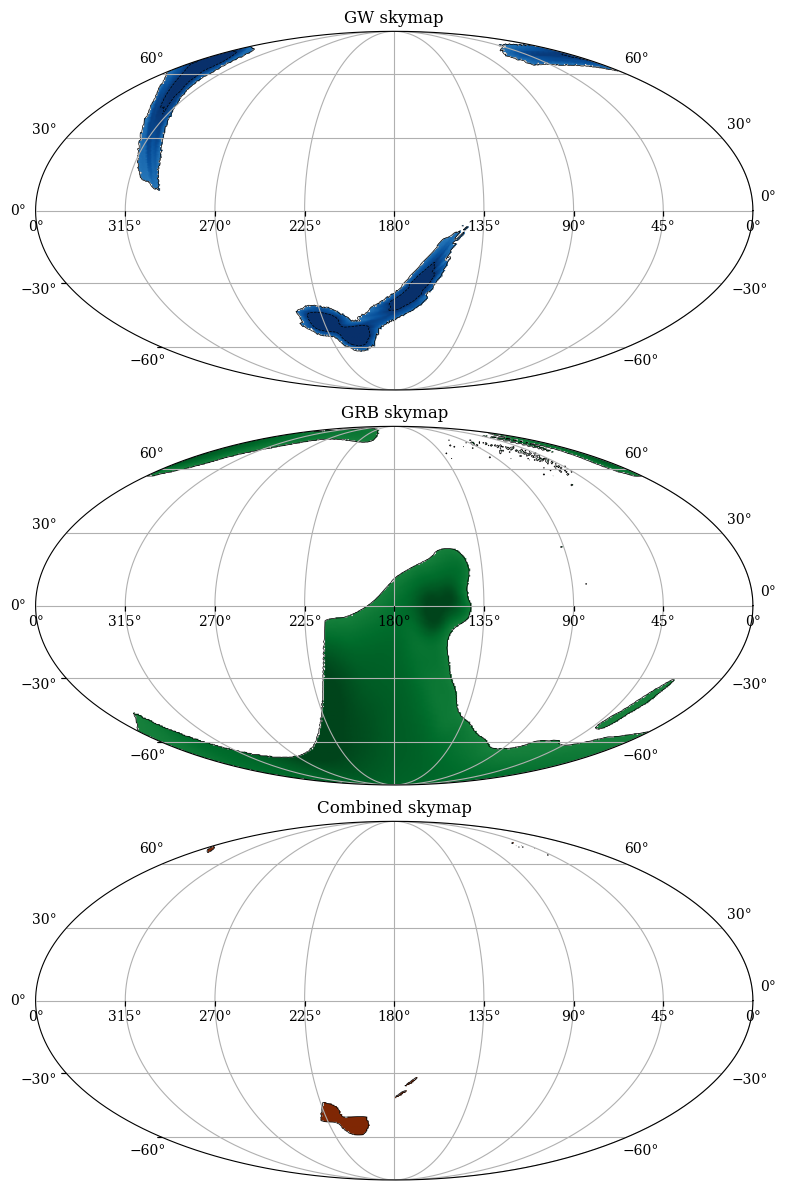

In [11]:
import matplotlib.pyplot as pp
from matplotlib.colors import LogNorm
from matplotlib import cm
import ligo.skymap.plot
import ligo.skymap.io.fits
import numpy as np

gw_map, _ = ligo.skymap.io.fits.read_sky_map('Bilby.multiorder.fits', nest=True)
grb_map, _ = ligo.skymap.io.fits.read_sky_map('754189311_0_n_PROBMAP.fits', nest=True)
comb_map, _ = ligo.skymap.io.fits.read_sky_map('combined_skymap.fits', nest=True)

def plot_panel(ax, skymap, title, cmap):
    import ligo.skymap.postprocess.util
    cls = 100 * ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)
    vmax = np.percentile(skymap[~np.isnan(skymap)], 99.0)
    vmin = np.percentile(skymap[~np.isnan(skymap)], 10.0)
    vmin = max(vmax/1e3, vmin)
    skymap_plot = skymap.copy()
    skymap_plot[cls > 90] = np.nan
    skymap_plot[skymap_plot == 0] = np.nan
    ax.set_facecolor('none')
    ax.grid()
    ax.imshow_hpx((skymap_plot, 'ICRS'), nested=True,
                  cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), zorder=0)
    ax.contour_hpx((cls, 'ICRS'), nested=True, colors='black',
                   levels=(50, 90), zorder=1,
                   linestyles=['dashed', 'solid'], linewidths=0.5)
    ax.set_title(title)

fig = pp.figure(figsize=(10, 12), dpi=100)

ax1 = pp.subplot(3, 1, 1, projection='astro degrees mollweide')
ax2 = pp.subplot(3, 1, 2, projection='astro degrees mollweide')

ax3 = pp.subplot(3, 1, 3, projection='astro degrees mollweide')
plot_panel(ax1, gw_map, 'GW skymap', cm.Blues)
plot_panel(ax2, grb_map, 'GRB skymap', cm.Greens)
plot_panel(ax3, comb_map, 'Combined skymap', cm.Oranges)

pp.tight_layout()
pp.show()

Zoom on the peak of the EXT map

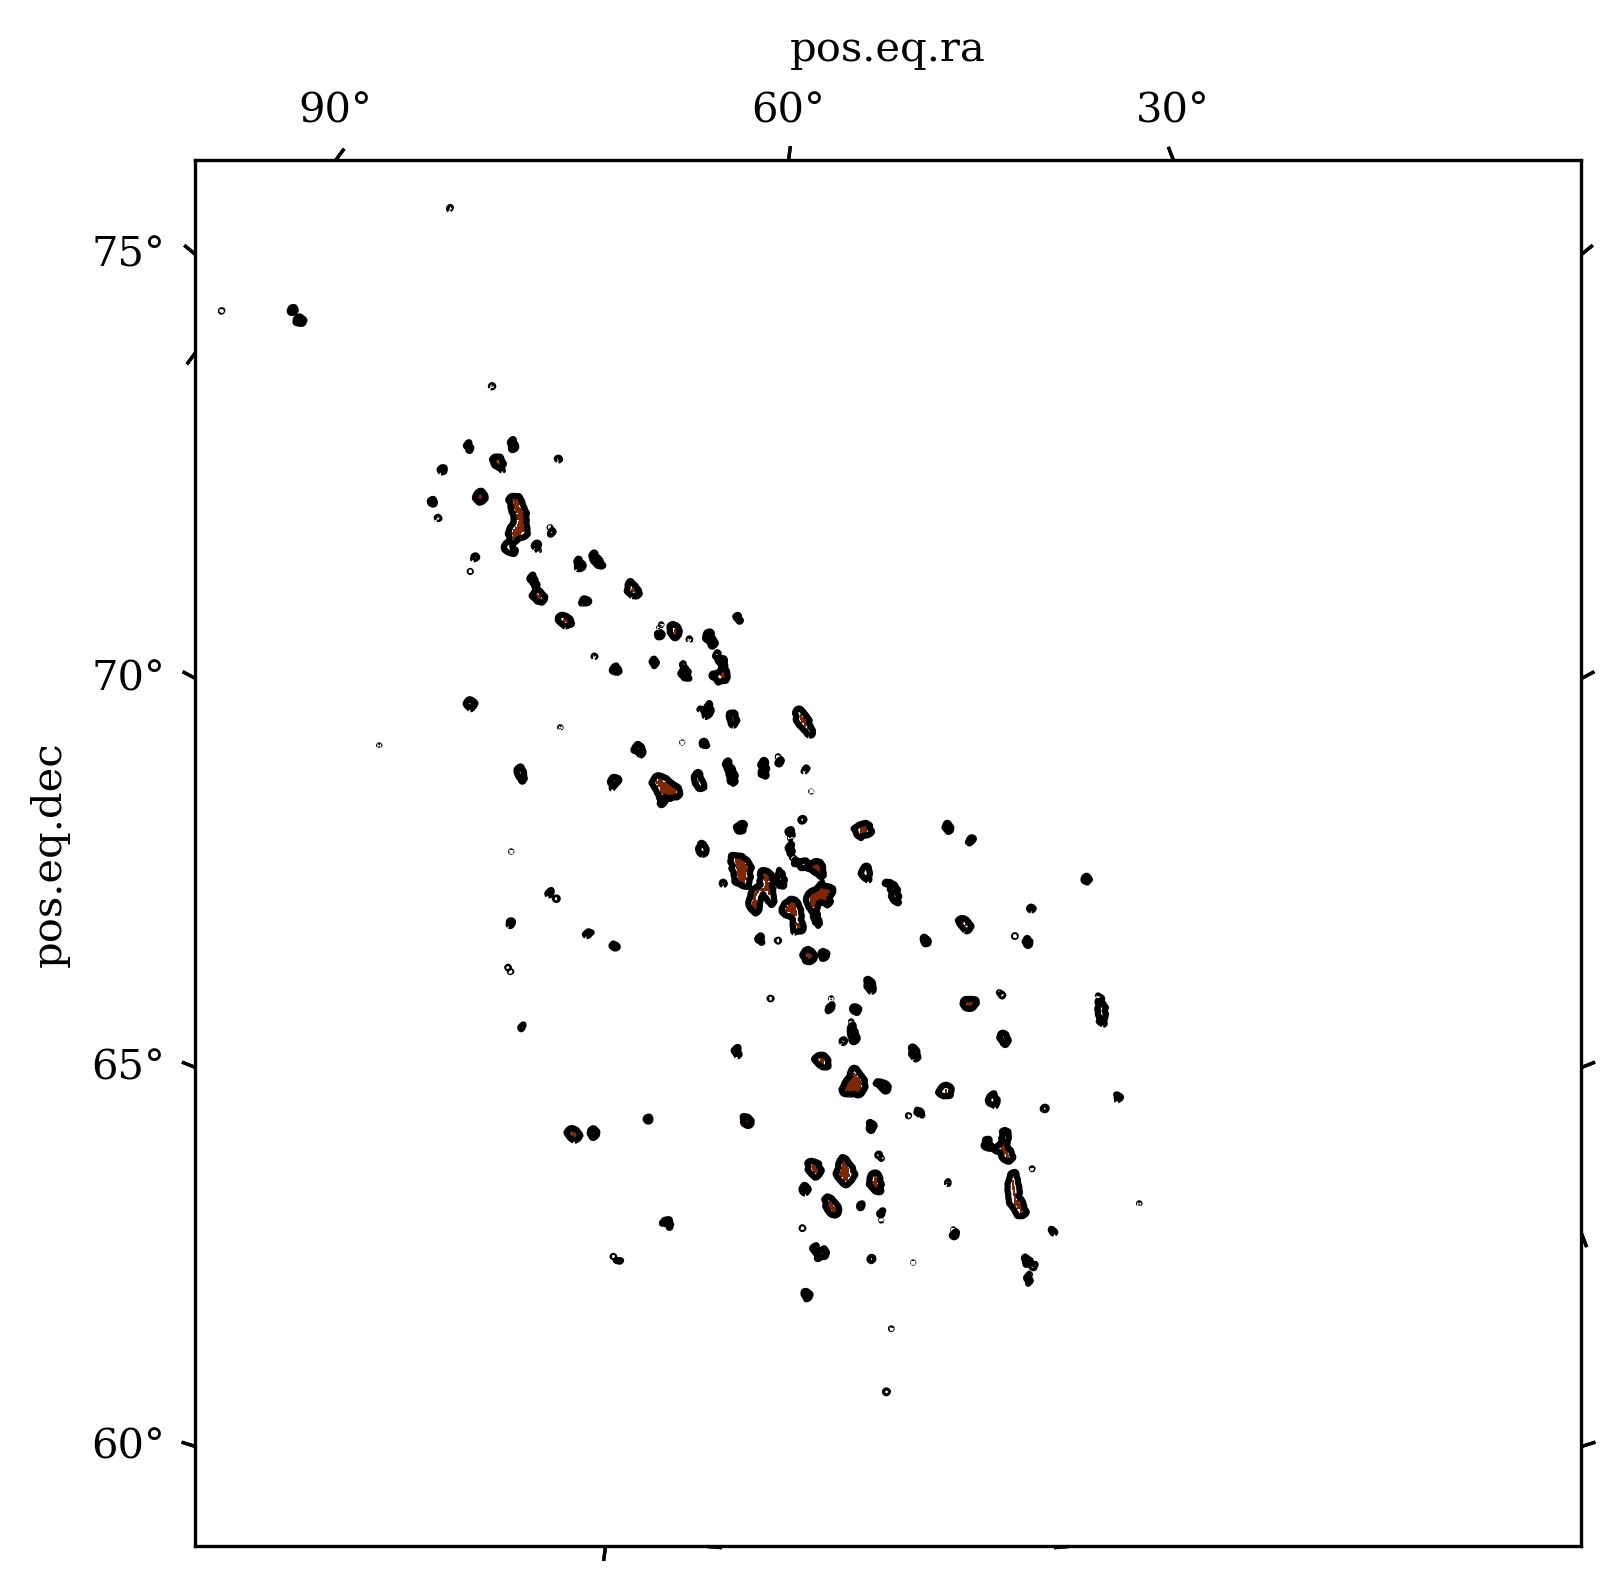

In [18]:
skymap, _ = ligo.skymap.io.fits.read_sky_map('combined_skymap.fits', nest = True) # NEST = True ensures that the order is rearranged properly, both for flat and multi-order maps

ax = pp.axes(projection='astro degrees zoom',
              center=f'52 d +70 d', radius='10 deg')

cls = 100 * ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)

vmax = np.percentile(skymap[~np.isnan(skymap)], 99.0)
vmin = np.percentile(skymap[~np.isnan(skymap)], 10.0)
vmin = max(vmax/1e3, vmin)

skymap[cls > 90] = np.nan
skymap[skymap == 0] = np.nan


ax.imshow_hpx((skymap, 'ICRS'), nested=True, cmap=cm.Oranges, norm=LogNorm(vmin=vmin, vmax=vmax), zorder=0)
ax.contour_hpx((cls, 'ICRS'), nested=True, colors='black', levels=(50, 90), zorder=1, linestyles=['dashed', 'solid'])

## How likely is to have randomly the sky overlap we obtain?

In [13]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as pp

random_overlaps = []
import ligo.skymap.plot
import ligo.skymap.io.fits
import numpy as np

gw_map, _ = ligo.skymap.io.fits.read_sky_map('Bilby.multiorder.fits', nest=True)
skymap_grb, _ = ligo.skymap.io.fits.read_sky_map('754189311_0_n_PROBMAP.fits', nest=True)

# Generate random rotation angles
n_rotations = 100
phis = np.random.uniform(0.0, 360.0, n_rotations)           # φ ~ U(0, 2π)
u = np.random.uniform(-1.0, 1.0, n_rotations)               # cosθ ~ U(-1, 1)
thetas = np.degrees(np.arccos(u))                           # θ = arccos(u)
psis = np.random.uniform(0.0, 360.0, n_rotations)           # ψ ~ U(0, 2π)

rotated_maps = np.array([
    hp.Rotator(rot=[phi, theta, psi], deg=True).rotate_map_pixel(gw_map)
    for phi, theta, psi in zip(phis, thetas, psis)
])




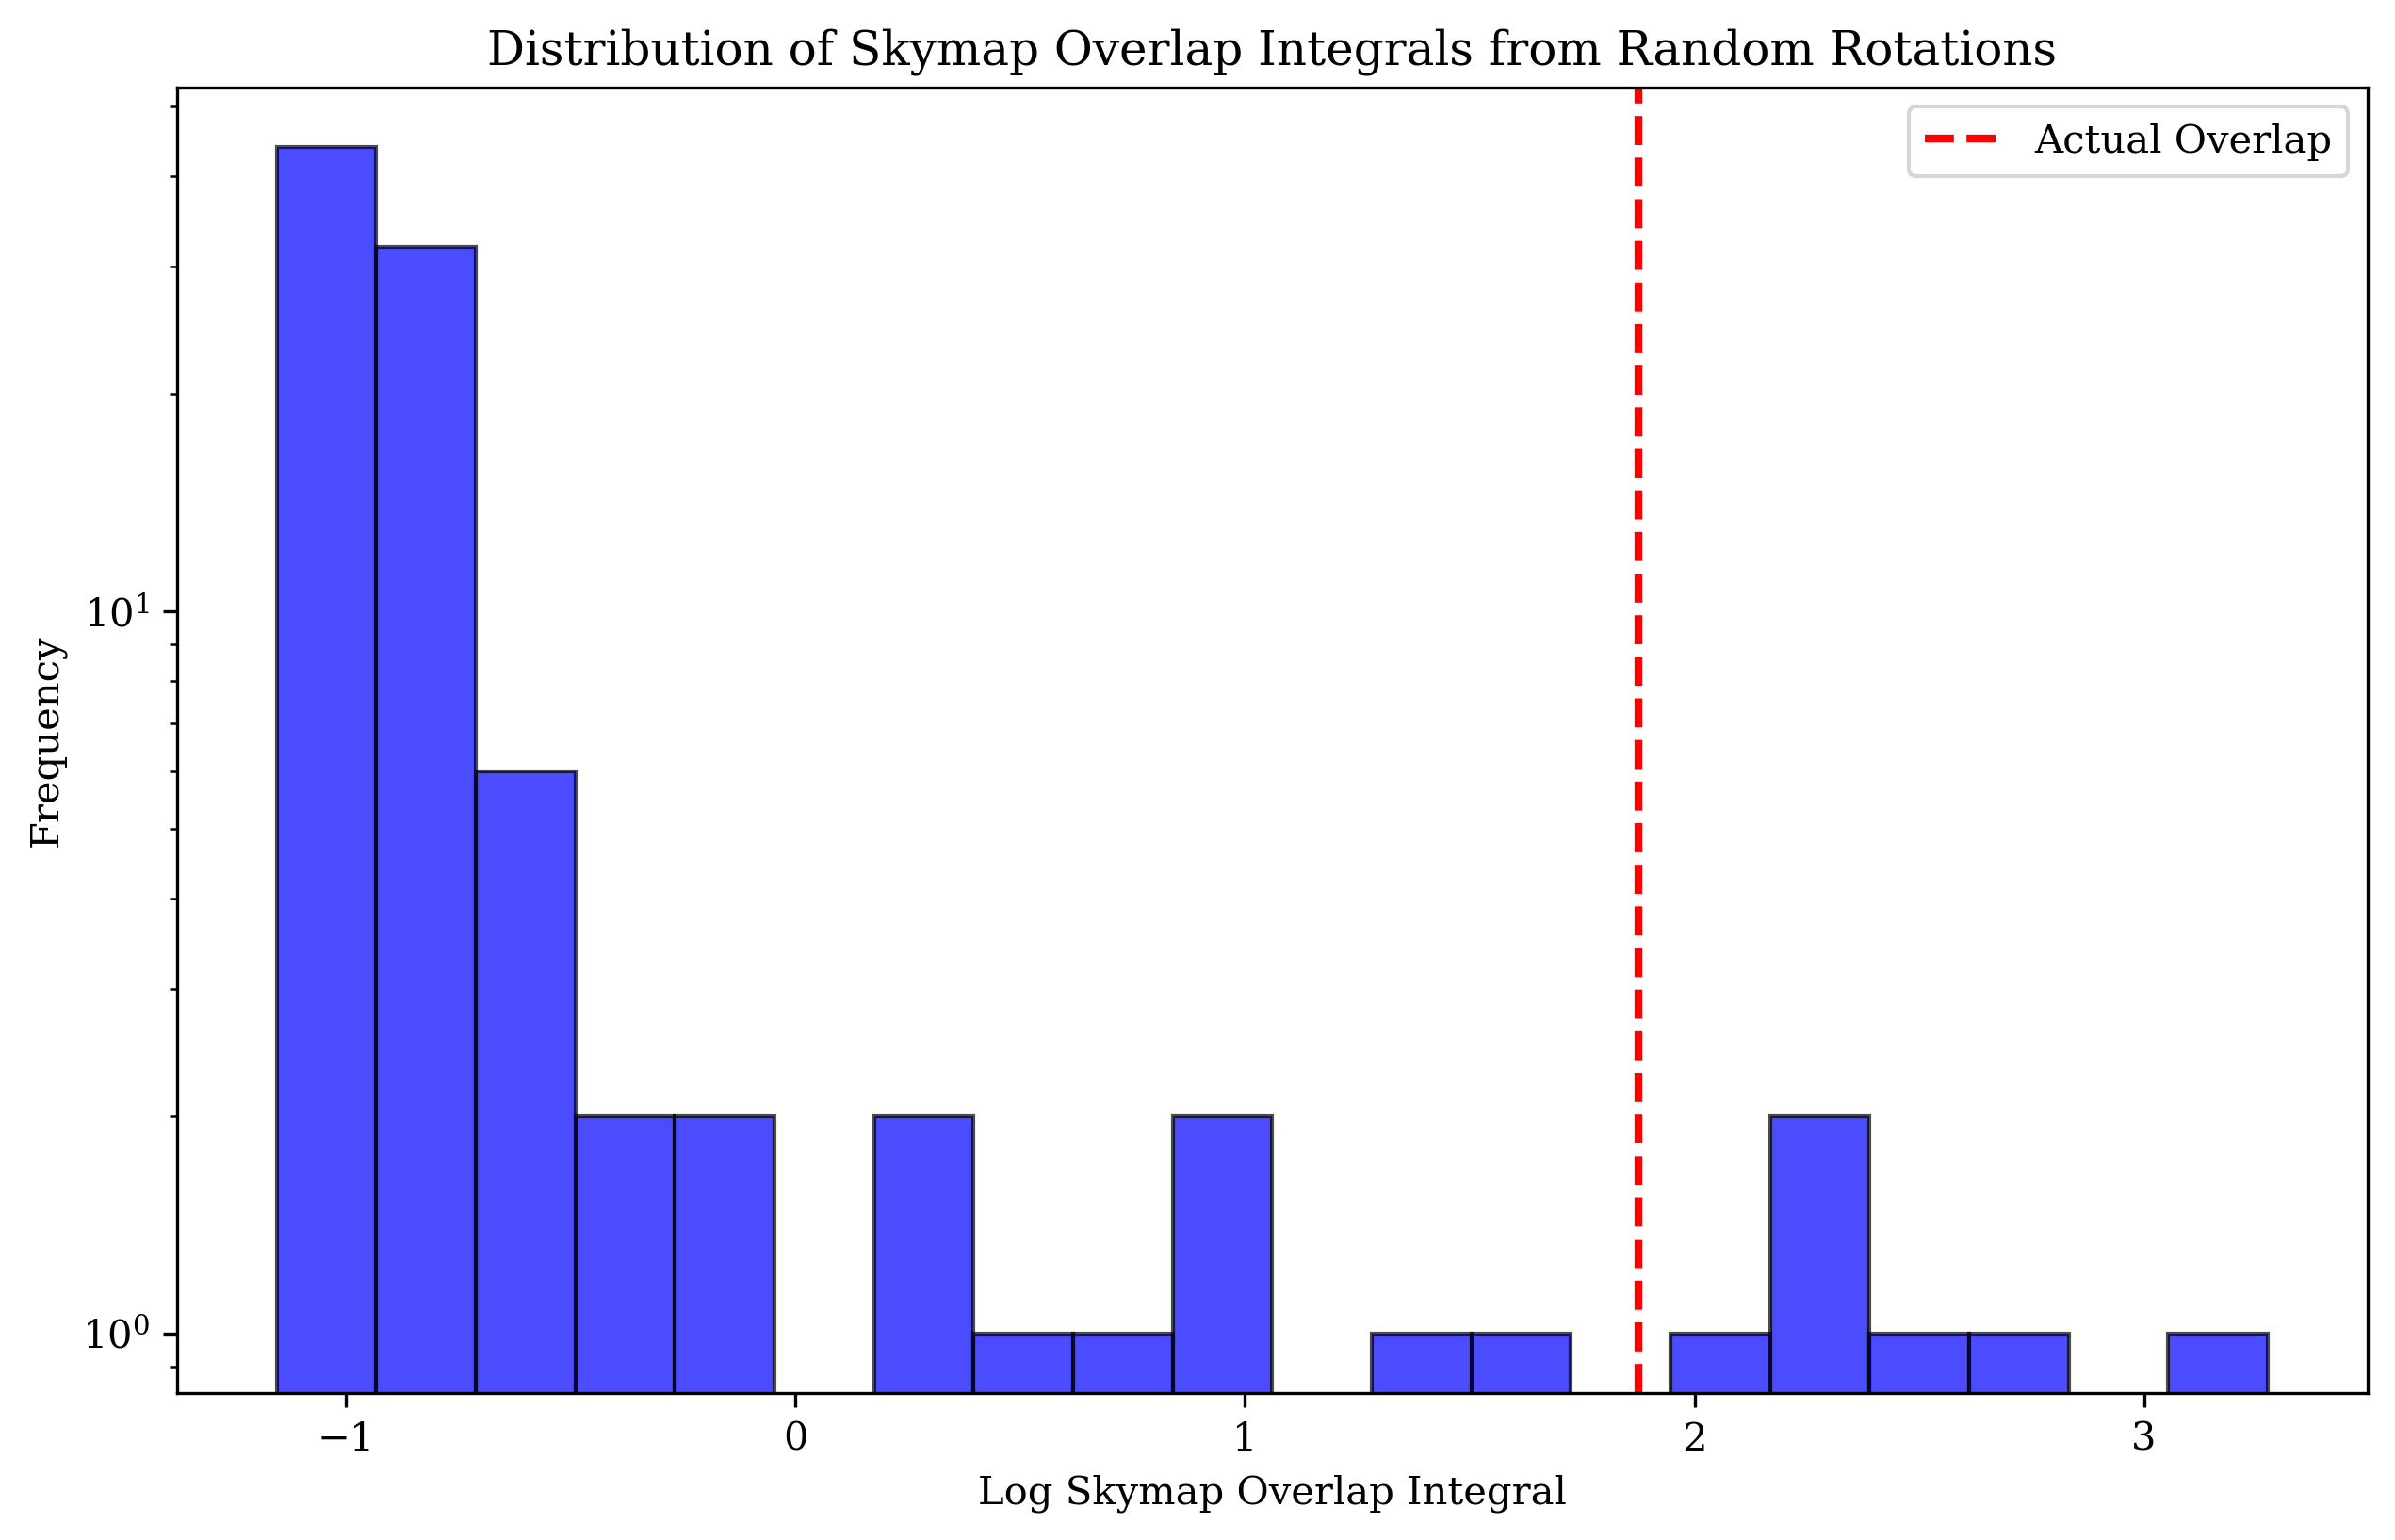

In [14]:
# Calculate overlaps for all rotated maps
skymap_grb, _ = ligo.skymap.io.fits.read_sky_map('754189311_0_n_PROBMAP.fits', nest=True)
random_overlaps = [np.log(search.skymap_overlap_integral(rotated_map, ext_skymap=skymap_grb)) 
                    for rotated_map in rotated_maps]

pp.hist(random_overlaps, bins=20, alpha=0.7, color='blue', edgecolor='black')
pp.axvline(np.log(sky_overlap), color='red', linestyle='dashed', linewidth=2, label='Actual Overlap')
pp.xlabel('Log Skymap Overlap Integral')
pp.ylabel('Frequency')
pp.yscale('log')
pp.title('Distribution of Skymap Overlap Integrals from Random Rotations')
pp.legend()

In [15]:
# number of random overlaps greater than or equal to the actual overlap
n_greater_equal = sum(1 for overlap in random_overlaps if overlap >= np.log(sky_overlap))
p_value = n_greater_equal / n_rotations
p_value

0.06

## Bonus: tiling the resulting joint map

In [20]:
def fibonacci_sphere(n_samples):
    """
    Generate uniformly distributed points on a sphere using Fibonacci lattice.
    This provides optimal uniform coverage - better than HEALPix for circle packing.
    
    Based on: "How to generate equidistributed points on the surface of a sphere"
    by Àlex Comas (2015) and Vogel's method.
    
    Parameters:
    -----------
    n_samples : int
        Number of points to generate
    
    Returns:
    --------
    ra, dec : arrays
        Right ascension and declination in degrees
    """
    golden_ratio = (1 + np.sqrt(5)) / 2
    
    # Generate indices
    i = np.arange(n_samples)
    
    # Latitude: uniform distribution in cos(theta) ensures equal-area spacing
    theta = np.arccos(1 - 2 * (i + 0.5) / n_samples)
    
    # Longitude: golden angle spiral
    phi = 2 * np.pi * i / golden_ratio
    
    # Convert to RA, Dec
    dec = 90 - np.rad2deg(theta)
    ra = np.rad2deg(phi) % 360
    
    return ra, dec



def optimize_circle_coverage(skymap, r_circle_deg, target_coverage=0.9):
    """
    Find optimal number of circles to cover target probability on skymap.
    Uses Fibonacci lattice for uniform initial distribution + greedy selection.
    OPTIMIZED: Pre-ranks circles by total probability, then uses a fast sequential
    pass that only evaluates uncovered gain for the next best candidates.
    
    Key features:
    - Hexagonal-like spacing proxy via spherical cap distance
    - No double-counting: tracks covered pixels to compute only new probability added
    - FAST: Avoids full best-search each iteration; walks sorted candidates
    
    Parameters:
    -----------
    r_circle_deg : float
        Circle radius in degrees
    target_coverage : float
        Target probability coverage (e.g., 0.9 for 90%)
    
    Returns:
    --------
    selected_circles : list of tuples
        (ra, dec, probability_added) for each selected circle
    """
    import healpy as hp
    import numpy as np
    
    r_rad = np.deg2rad(r_circle_deg)
    
    # Estimate sphere area that can be covered by one circle (spherical cap area)
    cap_area = 2 * np.pi * (1 - np.cos(r_rad))  # steradians
    sphere_area = 4 * np.pi  # steradians
    
    # Spacing guideline for spherical hex-like packing
    target_spacing_rad = 2 * np.arcsin(np.sqrt(3)/2 * np.sin(r_rad))
    
    # Candidate count heuristic
    points_per_steradian = 1 / (target_spacing_rad ** 2)
    n_candidates = int(sphere_area * points_per_steradian * 1.5)  # 50% extra
    
    print(f"Circle radius: {r_circle_deg}°")
    print(f"Spherical cap area: {np.rad2deg(np.rad2deg(cap_area)):.2f} deg²")
    print(f"Hexagonal packing spacing (spherical): {np.rad2deg(target_spacing_rad):.3f}°")
    print(f"Generating {n_candidates} candidate positions using Fibonacci lattice...")
    
    # Generate candidate centers
    ra_centers, dec_centers = fibonacci_sphere(n_candidates)
    
    # Prepare circle data with probability information
    nside = hp.npix2nside(len(skymap))
    circle_data = []
    
    # Precompute probabilities per candidate (total within disc)
    for ra_c, dec_c in zip(ra_centers, dec_centers):
        theta_c = np.radians(90 - dec_c)
        phi_c = np.radians(ra_c)
        xyz_c = hp.ang2vec(theta_c, phi_c)
        ipix_disc = np.array(hp.query_disc(nside, xyz_c, r_rad, nest=True), dtype=np.int32)
        total_prob = np.nansum(skymap[ipix_disc])
        circle_data.append((ra_c, dec_c, ipix_disc, total_prob))
    
    # Sort circles by total probability (descending) - pre-ranking step
    circle_data.sort(key=lambda x: x[3], reverse=True)
    
    selected_circles = []
    covered_pixels = np.zeros(len(skymap), dtype=bool)  # Boolean mask
    cumulative_prob = 0.0
    
    print(f"Running fast selection for {target_coverage:.0%} coverage...")
    iteration = 0
    
    # FAST PATH: iterate candidates in descending total_prob order
    for idx, (ra_c, dec_c, ipix_disc, total_prob) in enumerate(circle_data):
        if cumulative_prob >= target_coverage:
            break
        iteration += 1
        
        # Compute uncovered gain only for this candidate
        uncovered_mask = ~covered_pixels[ipix_disc]
        new_prob = np.nansum(skymap[ipix_disc[uncovered_mask]])
        
        # If adds something, accept and update covered mask
        if new_prob > 0:
            selected_circles.append((ra_c, dec_c, new_prob))
            covered_pixels[ipix_disc[uncovered_mask]] = True
            cumulative_prob += new_prob
            
            # Progress update every 10 accepts
            if len(selected_circles) % 10 == 0:
                avg_new_prob = cumulative_prob / len(selected_circles)
                #print(f"  Accepted {len(selected_circles)} circles, coverage: {cumulative_prob:.2%}, "
                #     f"avg new prob/circle: {avg_new_prob:.3%}")
    
    print(f"\n✓ Selected {len(selected_circles)} circles covering {cumulative_prob:.2%}")
    if len(selected_circles) > 0:
        print(f"  Average new probability per circle: {cumulative_prob/len(selected_circles):.3%}")
    print(f"  Total unique pixels covered: {np.sum(covered_pixels):,} (no double-counting)")
    
    return selected_circles



# Test with different circle sizes
r_circle = 23/2 / 60  # degrees
skymap, _ = ligo.skymap.io.fits.read_sky_map('combined_skymap.fits', nest = True) # NEST = True ensures that the order is rearranged properly, both for flat and multi-order maps
selected_circles = optimize_circle_coverage(skymap, r_circle, target_coverage=0.90)

Circle radius: 0.19166666666666668°
Spherical cap area: 0.12 deg²
Hexagonal packing spacing (spherical): 0.332°
Generating 561477 candidate positions using Fibonacci lattice...
Running fast selection for 90% coverage...

✓ Selected 2364 circles covering 90.00%
  Average new probability per circle: 0.038%
  Total unique pixels covered: 55,184 (no double-counting)
Running fast selection for 90% coverage...

✓ Selected 2364 circles covering 90.00%
  Average new probability per circle: 0.038%
  Total unique pixels covered: 55,184 (no double-counting)


Plotting 2364 optimized circles...


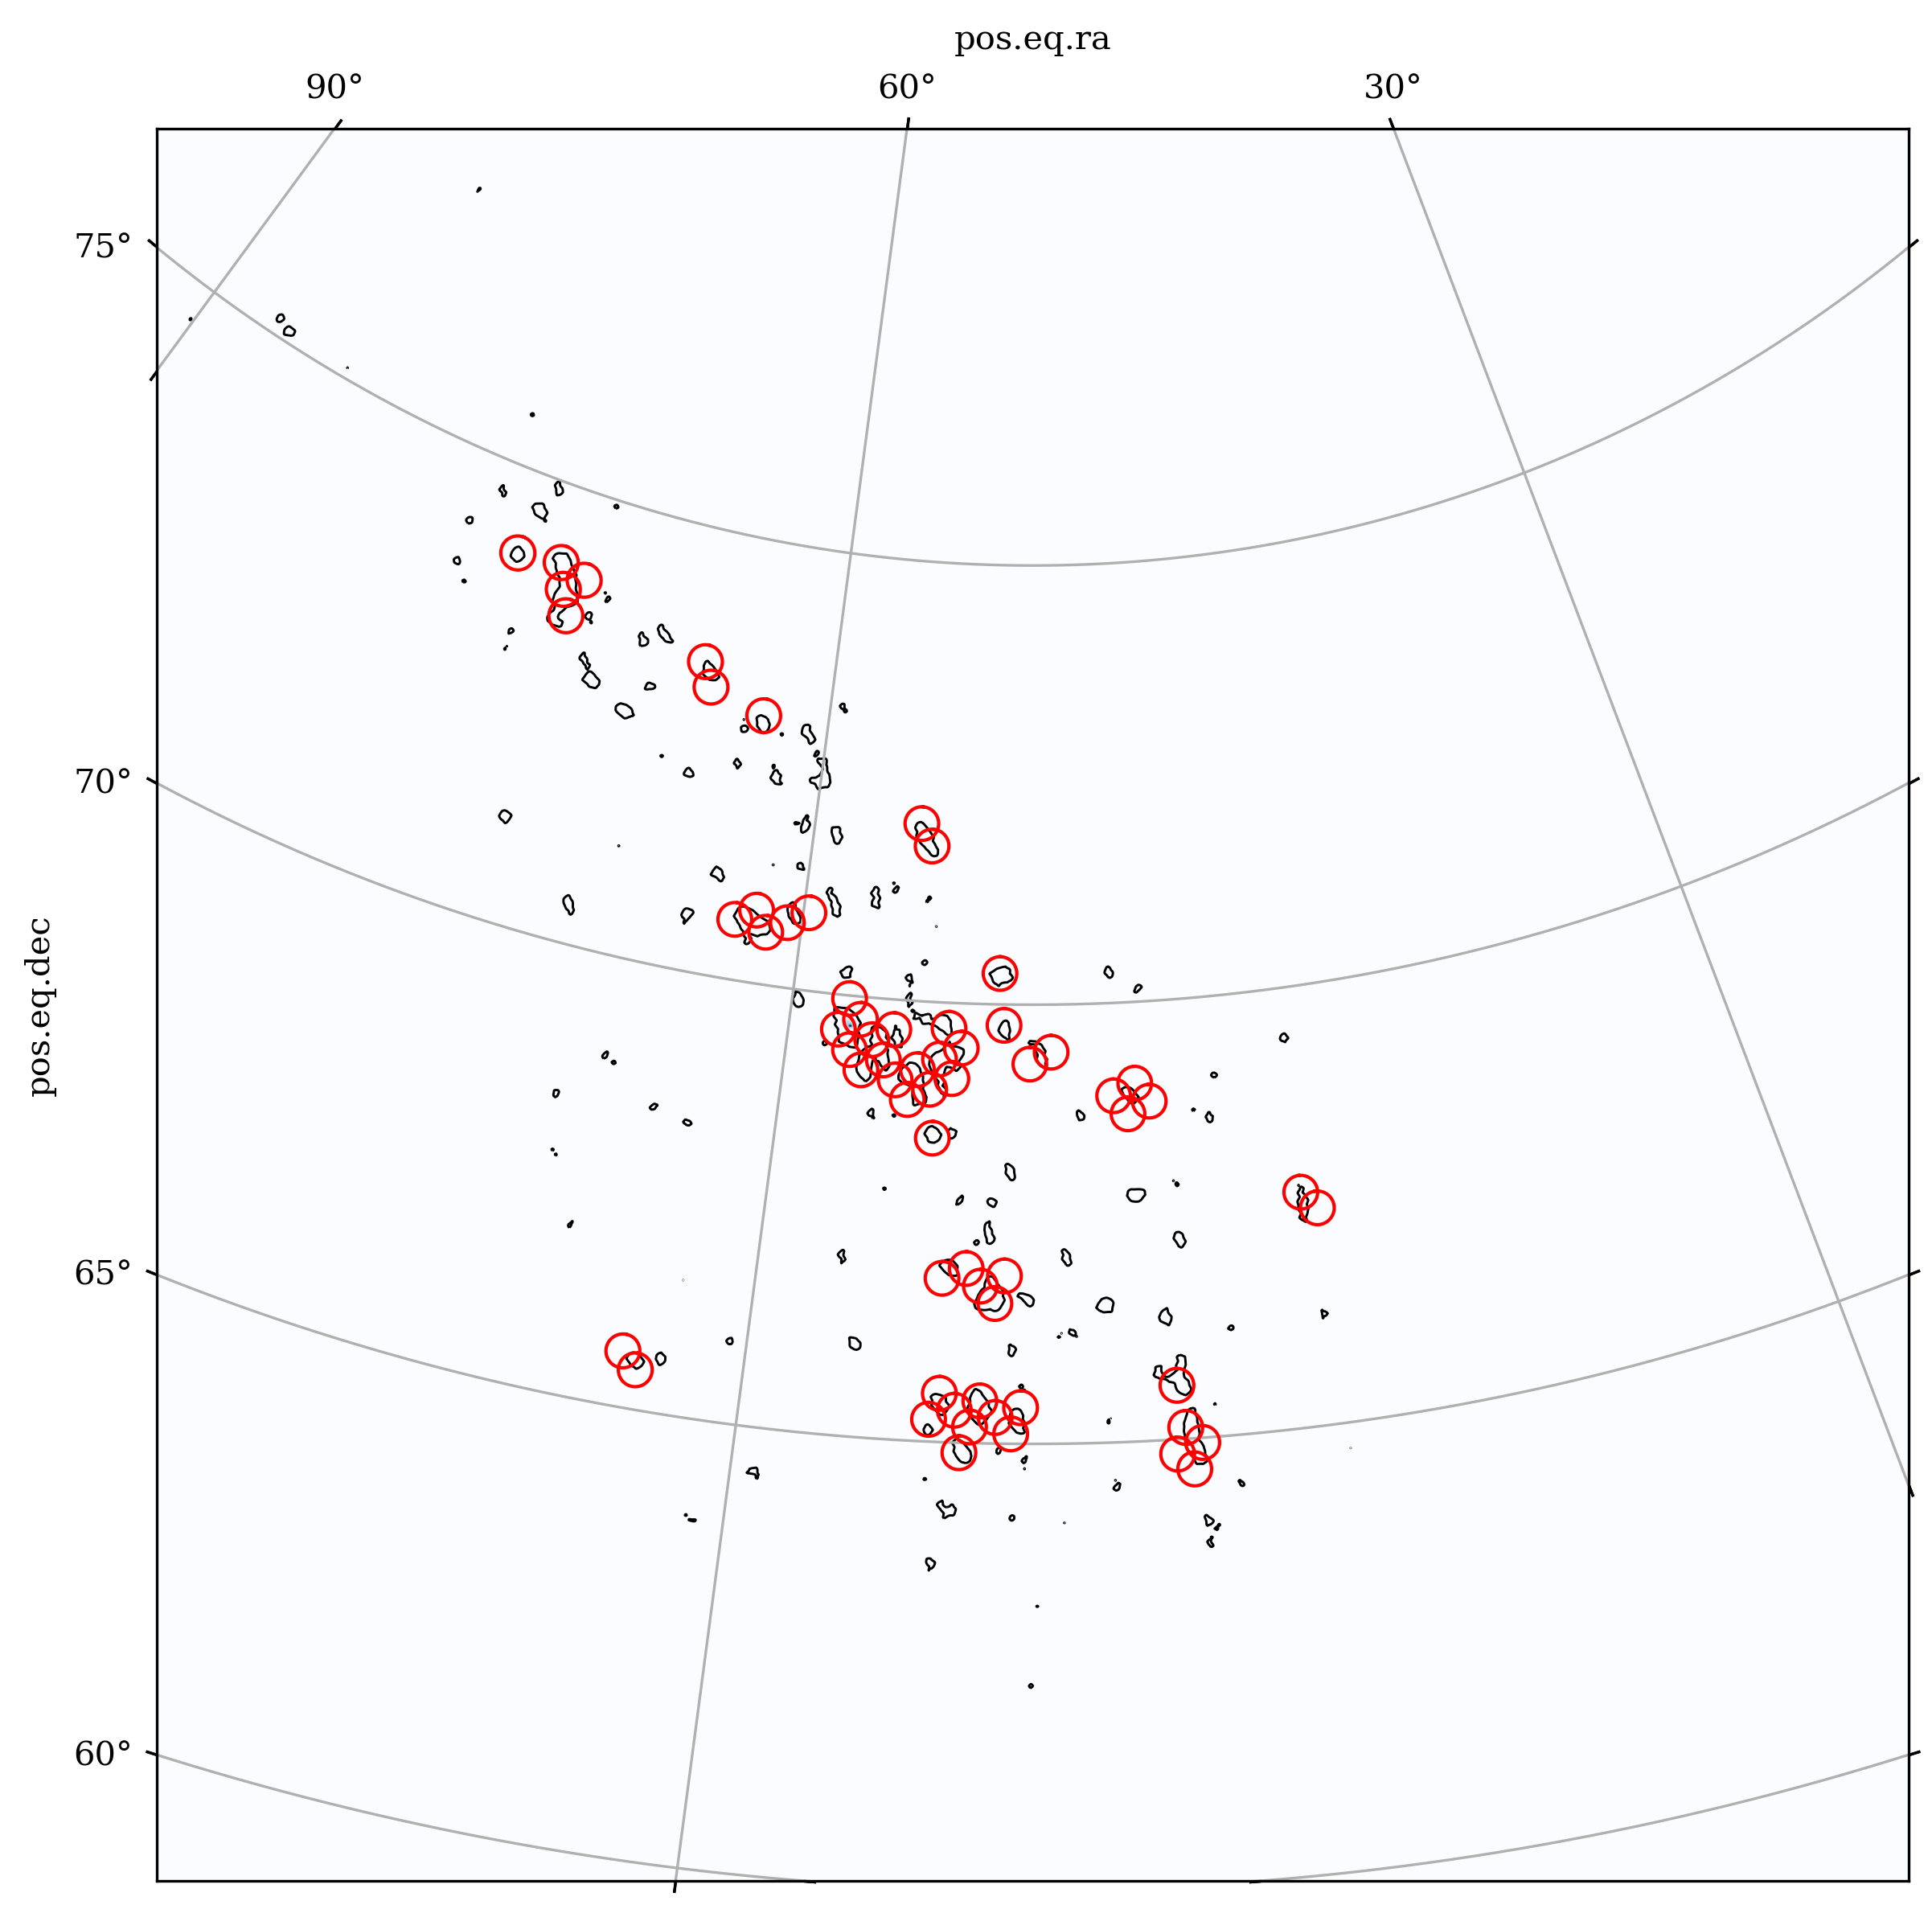

In [17]:
# Visualize the selected circles on the skymap
import matplotlib.pyplot as plt
import ligo.skymap.postprocess.util
from astropy import units as u

cls = 100 * ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap)

def plot_spherical_cap(ax, center_lon_deg, center_lat_deg, radius_deg,
                       npoints=720, fill=True, facecolor='none', edgecolor='red',
                       alpha=0.3, linewidth=0.8, zorder=5):
    """
    Plot a spherical cap (sphere ∩ cone) on an axes that accepts transform=ax.get_transform('icrs').
    center_lon_deg, center_lat_deg: degrees (RA/longitude, Dec/latitude in ICRS)
    radius_deg: angular radius of the cap in degrees
    npoints: number of points to sample boundary (higher -> smoother)
    
    Handles circles that cross the RA=0/360 boundary by splitting them into multiple segments.
    """
    # center as SkyCoord and radial positions around it
    center = SkyCoord(center_lon_deg * u.deg, center_lat_deg * u.deg, frame='icrs')
    pos_angles = np.linspace(0, 360, npoints) * u.deg
    boundary = center.directional_offset_by(pos_angles, radius_deg * u.deg)

    # Get RA in [0, 360) range
    ra = boundary.ra.deg
    dec = boundary.dec.deg

    # Detect large jumps in RA (>180 deg) indicating boundary crossing
    ra_diff = np.diff(ra)
    jumps = np.abs(ra_diff) > 180
    split_idx = np.where(jumps)[0]
    
    # Split into continuous segments
    segments = []
    start = 0
    for idx in split_idx:
        segments.append((ra[start:idx + 1], dec[start:idx + 1]))
        start = idx + 1
    segments.append((ra[start:], dec[start:]))

    # Plot each continuous segment
    transform = ax.get_transform('icrs')

    for seg_ra, seg_dec in segments:
        if len(seg_ra) < 2:
            continue
        if fill and facecolor != 'none':
            ax.fill(seg_ra, seg_dec, transform=transform,
                    facecolor=facecolor, edgecolor='none', alpha=alpha, zorder=zorder)
        # Always draw edge so the cap boundary is visible
        ax.plot(seg_ra, seg_dec, transform=transform, color=edgecolor,
                linewidth=linewidth, alpha=alpha, zorder=zorder + 1)
        
        # plot rank inside the cap
        


fig = plt.figure(figsize=(14, 8), dpi=300)
fig.patch.set_visible(False)
ax = pp.axes(projection='astro degrees zoom',
              center=f'52 d +70 d', radius='10 deg')
ax.set_facecolor('none')
ax.grid()

# Plot skymap
ax.imshow_hpx((skymap, 'ICRS'), nested=True, cmap='Blues', alpha=0.6)
ax.contour_hpx((cls, 'ICRS'), nested=True, colors='black',
               levels=(50, 90), zorder=1, linestyles=['dashed', 'solid'],
               linewidths=0.7)

# Plot selected circles as spherical caps
from astropy.coordinates import SkyCoord
print(f"Plotting {len(selected_circles)} optimized circles...")
rank = 1
for ra_c, dec_c, prob in selected_circles:
    plot_spherical_cap(ax, center_lon_deg=ra_c, center_lat_deg=dec_c, 
                       radius_deg=r_circle,
                       npoints=360, fill=False, facecolor='none', 
                       edgecolor='red', alpha=1, linewidth=1)

    # ax.text(ra_c, dec_c, str(rank), color='black', fontsize=8,
    #         ha='center', va='center', zorder=10, transform=ax.get_transform('icrs'))
    rank += 1


plt.tight_layout()
plt.show()